In [28]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from keras.models import Model

ModuleNotFoundError: No module named 'h2o'

In [2]:
train = pd.read_csv('C:/Users/daniel.brooks/Documents/GitHub/Kaggle/June Playground/train.csv')
test = pd.read_csv('C:/Users/daniel.brooks/Documents/GitHub/Kaggle/June Playground/test.csv')

target = pd.get_dummies(train['target'])
y = train['target']

X = train.iloc[:,1:-1]
test = test.iloc[:,1:]

train.shape, test.shape

((200000, 77), (100000, 75))

In [3]:
print("Training Data Sparsity: {0}%".format(round(sum(train.drop(['id', 'target'], axis=1).apply(lambda x: sum(x==0)))/(train.size)*100)))

Training Data Sparsity: 63%


Text(0.5, 1.0, 'Target Distribution')

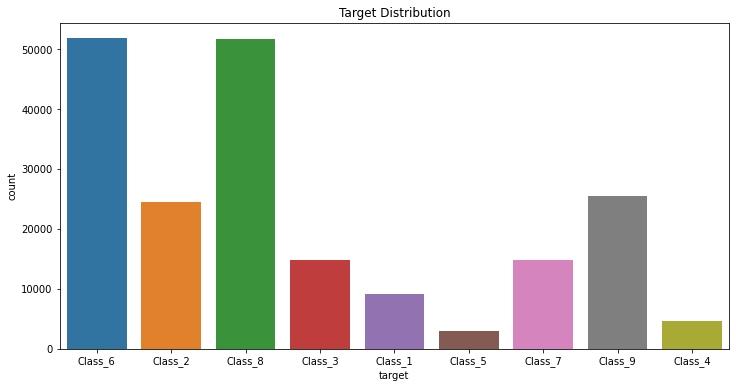

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='target', data=train)
ax.set_title('Target Distribution')

<AxesSubplot:>

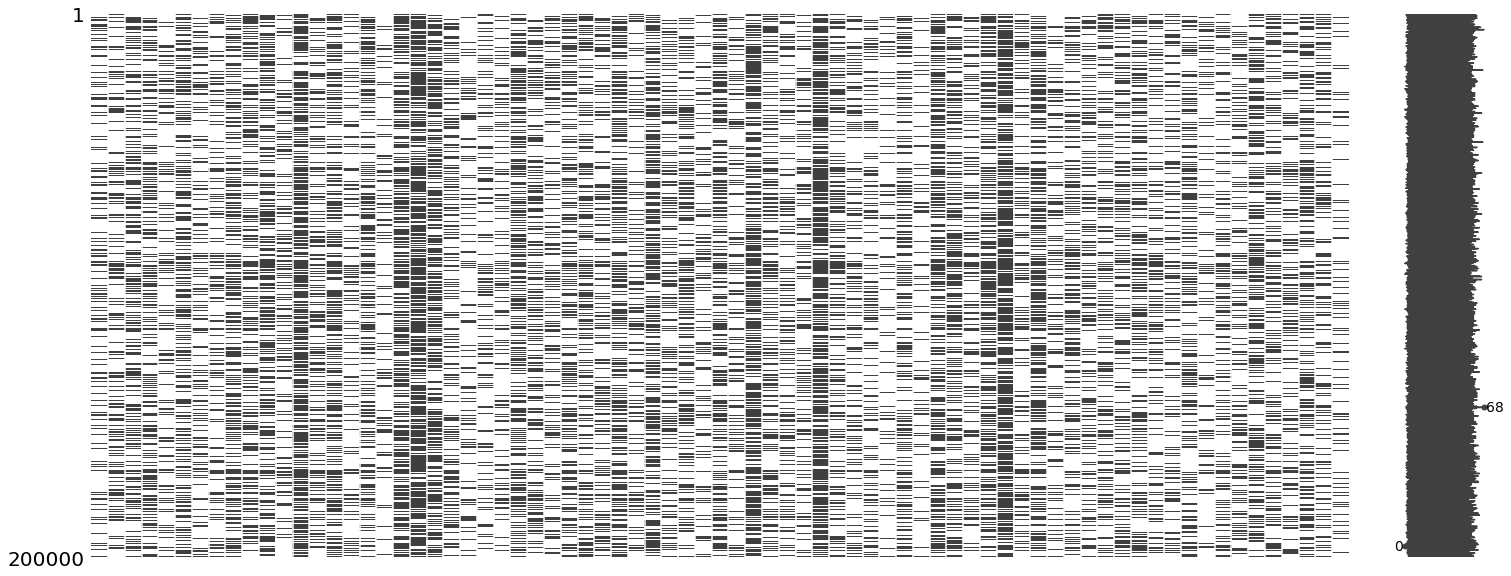

In [5]:
foo = train.replace(0, np.nan)
msno.matrix(foo.drop(['id', 'target'], axis=1))

In [6]:
train.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
id,200000.000000,99999.500000,57735.171256,0.000000,49999.750000,99999.500000,149999.250000,199999.000000
feature_0,200000.000000,0.972710,3.941836,0.000000,0.000000,0.000000,1.000000,61.000000
feature_1,200000.000000,1.168365,3.993407,0.000000,0.000000,0.000000,1.000000,51.000000
feature_2,200000.000000,2.219325,6.476570,0.000000,0.000000,0.000000,1.000000,64.000000
feature_3,200000.000000,2.296735,7.551858,0.000000,0.000000,0.000000,1.000000,70.000000
feature_4,200000.000000,0.793530,2.935785,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,200000.000000,1.431105,5.162746,0.000000,0.000000,0.000000,1.000000,76.000000
feature_6,200000.000000,1.010695,3.949231,0.000000,0.000000,0.000000,0.000000,43.000000
feature_7,200000.000000,0.673090,2.234949,0.000000,0.000000,0.000000,0.000000,30.000000
feature_8,200000.000000,1.943980,3.931330,0.000000,0.000000,0.000000,2.000000,38.000000


In [7]:
def embedding_arch():
    inputs = layers.Input(shape=(75,), name='Input')
    x = layers.Embedding(400, 20, input_length=256)(inputs)
    x = layers.Flatten()(x)
    x = layers.Dropout(.25)(x)
    x = layers.Dense(100, activation=tf.keras.activations.relu)(x)
    x = layers.Dense(50, activation=tf.keras.activations.relu)(x)
    x = layers.Dense(18, activation=tf.keras.activations.relu)(x)
    out = layers.Dense(9, activation='softmax', name='out')(x)
    model = Model(inputs, out)

    return model
    

In [8]:
es = callbacks.EarlyStopping(
    monitor = 'val_categorical_crossentropy', 
    min_delta = 0.0000001, 
    patience = 2,
    mode = 'min',
    baseline = None, 
    restore_best_weights = True,
    verbose = 1)


plateau  = callbacks.ReduceLROnPlateau(
                monitor = 'val_categorical_crossentropy',
                factor = 0.5, 
                patience = 2, 
                mode = 'min', 
                min_delt = 0.0000001,
                cooldown = 0, 
                min_lr = 1e-7,
                verbose = 1) 

metrics = [tf.keras.metrics.CategoricalCrossentropy()]
loss = tf.keras.losses.CategoricalCrossentropy(
                from_logits=False,
                label_smoothing=0,
                reduction="auto",
                name="categorical_crossentropy")

In [12]:
N_FOLDS = 10
SEED = 2021
oof = np.zeros((X.shape[0],9))
pred = np.zeros((test.shape[0],9))


skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(X, y)):
    print(f"===== FOLD {fold} =====")
       
    x_tr = X.iloc[tr_idx] 
    y_tr = target.iloc[tr_idx] 
    
    x_ts = X.iloc[ts_idx] 
    y_ts = target.iloc[ts_idx] 

    model_nn= embedding_arch()

    model_nn.compile(optimizer='adam',
            loss = loss ,
            metrics = metrics)
    
    model_nn.fit(x_tr,
                y_tr,
                validation_data = (x_ts, y_ts),
                batch_size = 256,
                epochs = 50,
                verbose = 1,
                callbacks = [es,plateau])
    
    
    oof[ts_idx] = model_nn.predict(x_ts)

    score = log_loss(y_ts, oof[ts_idx])
    print(f"FOLD {fold} Score {score}\n")
    
    pred += model_nn.predict(test)/ N_FOLDS

score = log_loss(target, oof)
print(f"Score total {score}\n")  

===== FOLD 0 =====
Epoch 1/50
704/704 [==============================] - 14s 4ms/step - loss: 1.8229 - categorical_crossentropy: 1.8986 - val_loss: 1.7490 - val_categorical_crossentropy: 1.7691
Epoch 2/50
704/704 [==============================] - 3s 4ms/step - loss: 1.7461 - categorical_crossentropy: 1.7645 - val_loss: 1.7450 - val_categorical_crossentropy: 1.7567
Epoch 3/50
704/704 [==============================] - 3s 4ms/step - loss: 1.7422 - categorical_crossentropy: 1.7550 - val_loss: 1.7440 - val_categorical_crossentropy: 1.7513
Epoch 4/50
704/704 [==============================] - 3s 4ms/step - loss: 1.7322 - categorical_crossentropy: 1.7499 - val_loss: 1.7491 - val_categorical_crossentropy: 1.7475
Epoch 5/50
704/704 [==============================] - 2s 4ms/step - loss: 1.7278 - categorical_crossentropy: 1.7465 - val_loss: 1.7522 - val_categorical_crossentropy: 1.7443
Epoch 6/50
704/704 [==============================] - 2s 4ms/step - loss: 1.7173 - categorical_crossentropy: 1

In [23]:
test = pd.read_csv('C:/Users/daniel.brooks/Documents/GitHub/Kaggle/June Playground/test.csv')
submission = pd.DataFrame(pred, columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'])
submission['id'] = test['id']
submission = submission[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']]

In [27]:
submission.to_csv('C:/Users/daniel.brooks/Documents/GitHub/Kaggle/June Playground/submission.csv', index=False)